https://github.com/topics/customer-churn-prediction

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,KFold,GridSearchCV,cross_val_predict
import os
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import shap
shap.initjs()

In [86]:
from sklearn.model_selection import StratifiedKFold


In [87]:
pd.set_option('display.max_columns',100)

In [88]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'catboost_info',
 'customer_churn_model-xgboost.ipynb',
 'customer_churn_model.ipynb',
 'README.md',
 'Telco-Customer-Churn.csv']

In [89]:
data=pd.read_csv("Telco-Customer-Churn.csv")

In [90]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Missingvalues

In [92]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

__check for no of unique values, remove column if there is only one unique value in it.__

In [93]:
data_len=data.nunique().reset_index()
data_len.columns=["column",'unique_count']
data_len

,column,unique_count
0,customerID,7043
1,gender,2
2,SeniorCitizen,2
3,Partner,2
4,Dependents,2
5,tenure,73
6,PhoneService,2
7,MultipleLines,3
8,InternetService,3
9,OnlineSecurity,3


__TotalCharges is a numerical column but is in string format, we need to convert it into numerical format__

In [94]:
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"], errors='coerce')

__After converting to numeric again check for null values__

In [95]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [96]:
data[data["TotalCharges"].isna()==True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


__Fill null values with mean__

In [97]:
data["TotalCharges"].fillna(int(data["TotalCharges"].mean()), inplace=True)

__Drop the customerid as it is not required for training__

In [98]:
data=data.drop(["customerID"],axis=1)

In [99]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [100]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.299972
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### Outliers

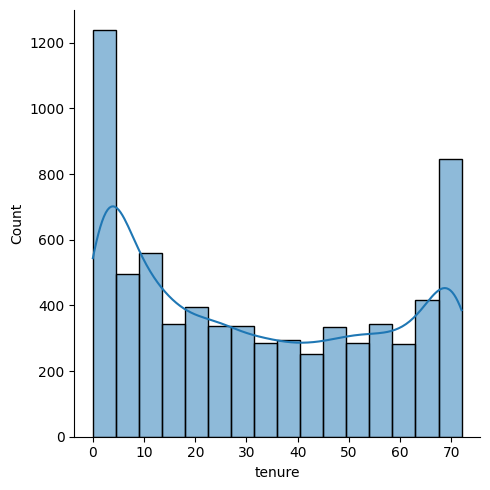

In [101]:
sns.displot(data["tenure"],kde=True)

<AxesSubplot: xlabel='Churn', ylabel='tenure'>

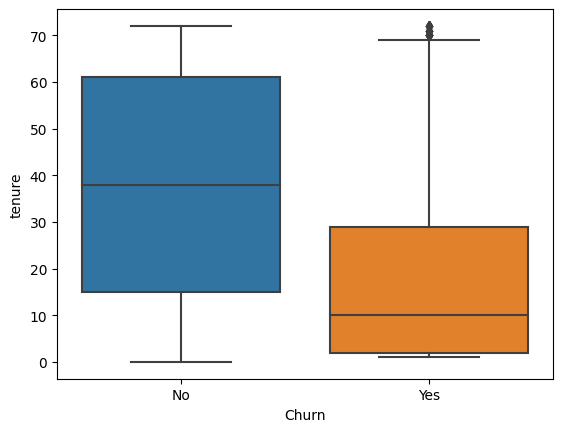

In [102]:
sns.boxplot(x="Churn",y="tenure",data=data)

In [103]:
def outliers_IQR(data,column):
    highest=data[column].mean() + 3*data[column].std()
    lowest=data[column].mean() - 3*data[column].std()
    return highest,lowest

In [104]:
highest,lowest=outliers_IQR(data,"tenure")
print(highest,lowest)
data[(data["tenure"] > highest) | (data["tenure"] < lowest)]


106.04959172752561 -41.30729441104115


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


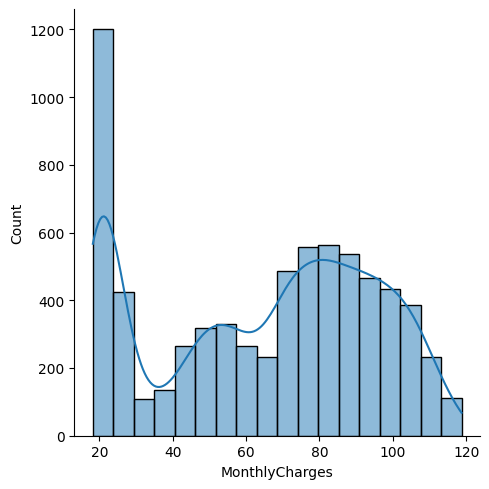

In [105]:
sns.displot(data["MonthlyCharges"],kde=True)

<AxesSubplot: xlabel='Churn', ylabel='MonthlyCharges'>

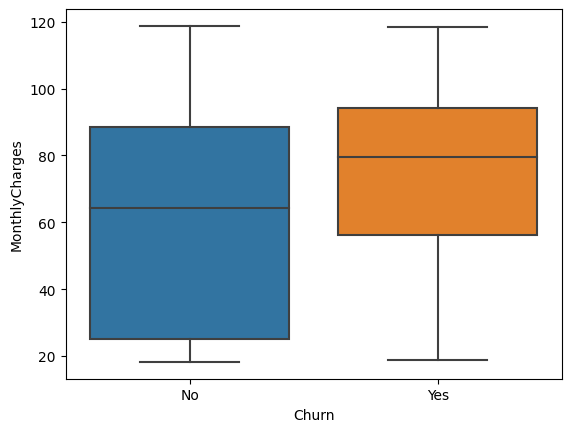

In [106]:
sns.boxplot(x="Churn",y="MonthlyCharges",data=data)

In [107]:
highest,lowest=outliers_IQR(data,"MonthlyCharges")
print(highest,lowest)
data[(data["MonthlyCharges"] > highest) | (data["MonthlyCharges"] < lowest)]

155.03183375363466 -25.5084488324363


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


<AxesSubplot: xlabel='Churn', ylabel='TotalCharges'>

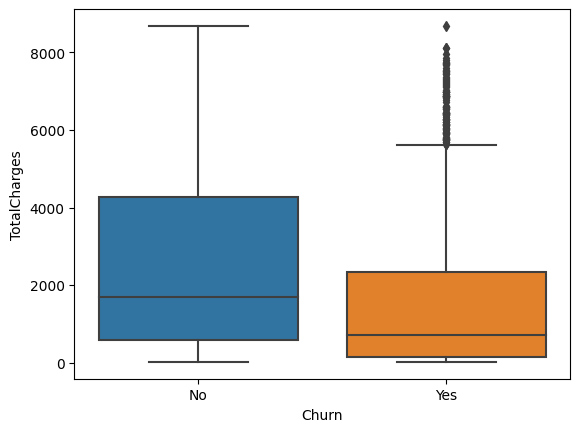

In [108]:
sns.boxplot(x="Churn",y="TotalCharges",data=data)

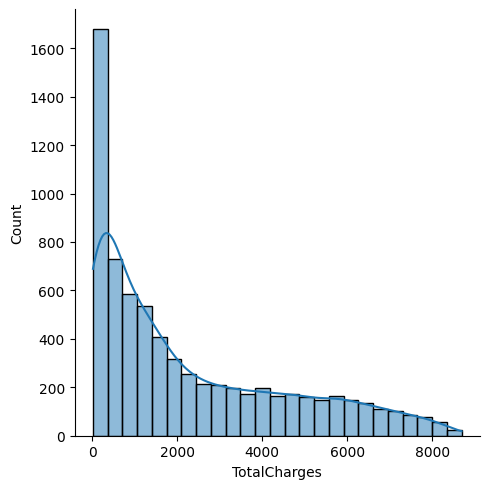

In [109]:
sns.displot(data["TotalCharges"],kde=True)

In [110]:
highest,lowest=outliers_IQR(data,"TotalCharges")
print(highest,lowest)
data[(data["TotalCharges"] > highest) | (data["TotalCharges"] < lowest)]

9078.300745106222 -4511.700801900202


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [111]:
data["Churn"].value_counts()


No     5174
Yes    1869
Name: Churn, dtype: int64

In [112]:
categorical=list(data.dtypes[data.dtypes=="object"].index.values)
categorical

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [113]:
cat_data=data[categorical]

In [114]:
numerical=list(data.dtypes[data.dtypes!="object"].index.values)
numerical

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [115]:
cat_len=data[categorical].nunique().reset_index()
cat_len.columns=["column",'unique_count']
cat_len

,column,unique_count
0,gender,2
1,Partner,2
2,Dependents,2
3,PhoneService,2
4,MultipleLines,3
5,InternetService,3
6,OnlineSecurity,3
7,OnlineBackup,3
8,DeviceProtection,3
9,TechSupport,3


In [116]:
 for column in categorical:
        if data[column].nunique()==2:
            print(column,data[column].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Churn ['No' 'Yes']


### Encoding

In [117]:
def label_encoding(data,columns):
    label_encoder = LabelEncoder()
    for column in columns:
        if data[column].nunique()==2:
            data[column]= label_encoder.fit_transform(data[column])
            print(column,data[column].unique())
    return data
data=label_encoding(data,categorical)            

gender [0 1]
Partner [1 0]
Dependents [0 1]
PhoneService [0 1]
PaperlessBilling [1 0]
Churn [0 1]


In [118]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [119]:
cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols2:
    data[col] = data[col].map({'No internet service': -1, 'No': 0, 'Yes': 1})
    

In [120]:
data["MultipleLines"] = data["MultipleLines"].map({'No phone service': 0, 'No': 0, 'Yes': 1})

In [121]:
data= pd.get_dummies(data, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

In [122]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


<AxesSubplot: >

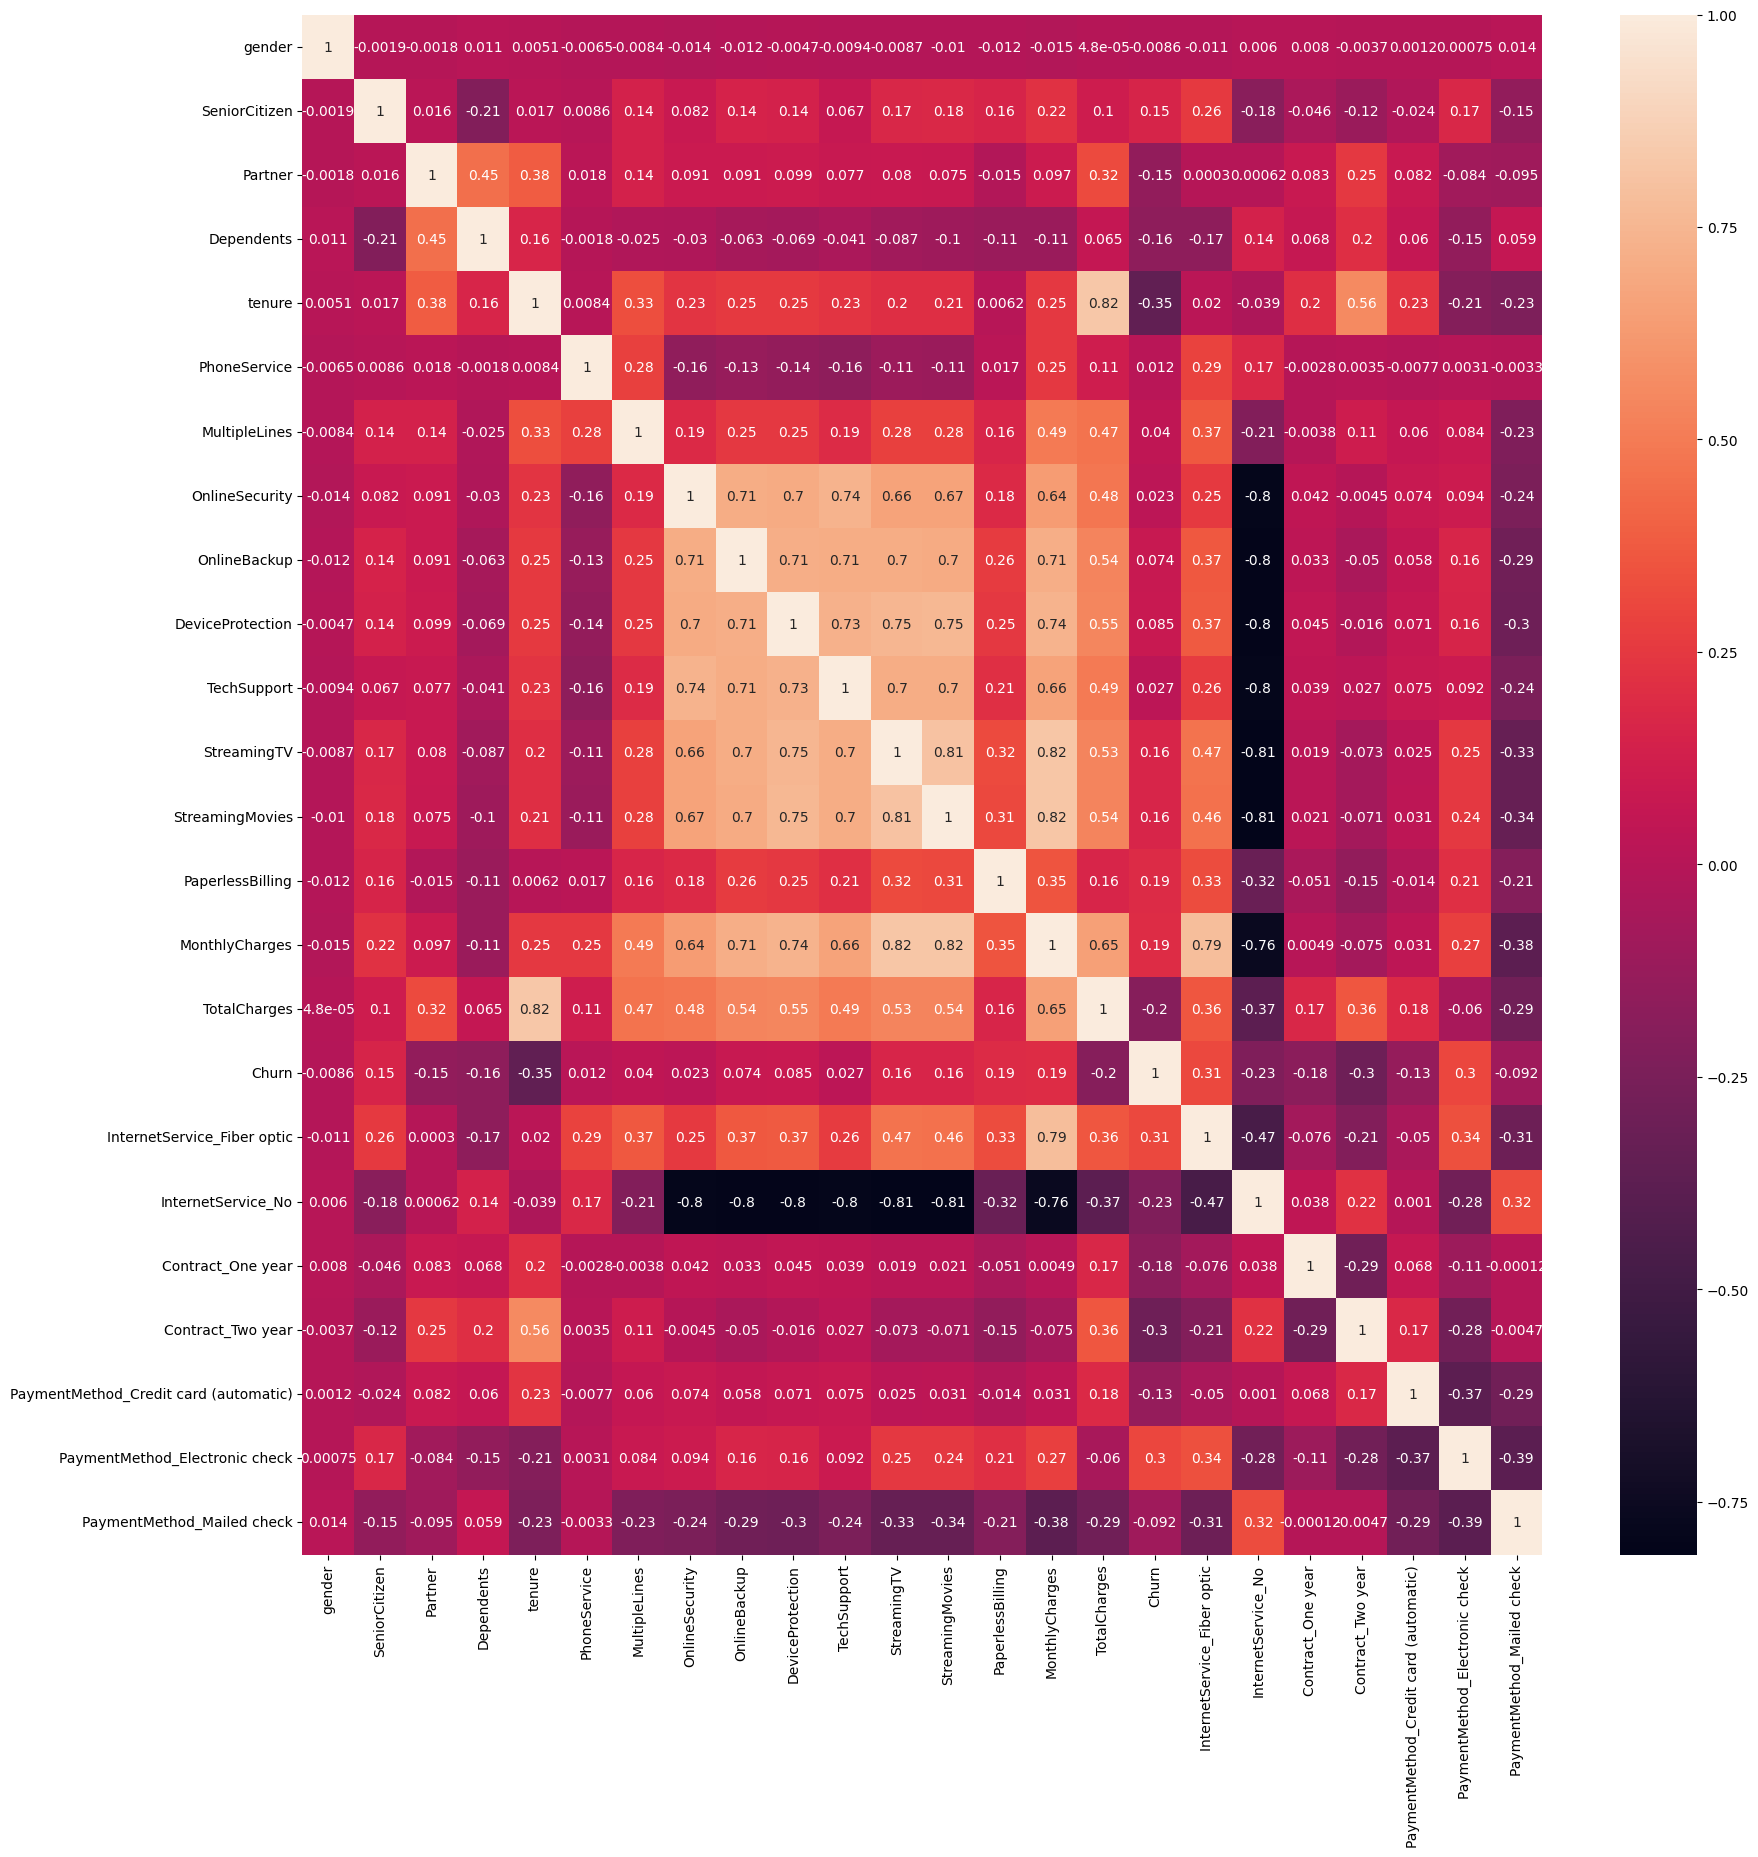

In [123]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True)

<AxesSubplot: >

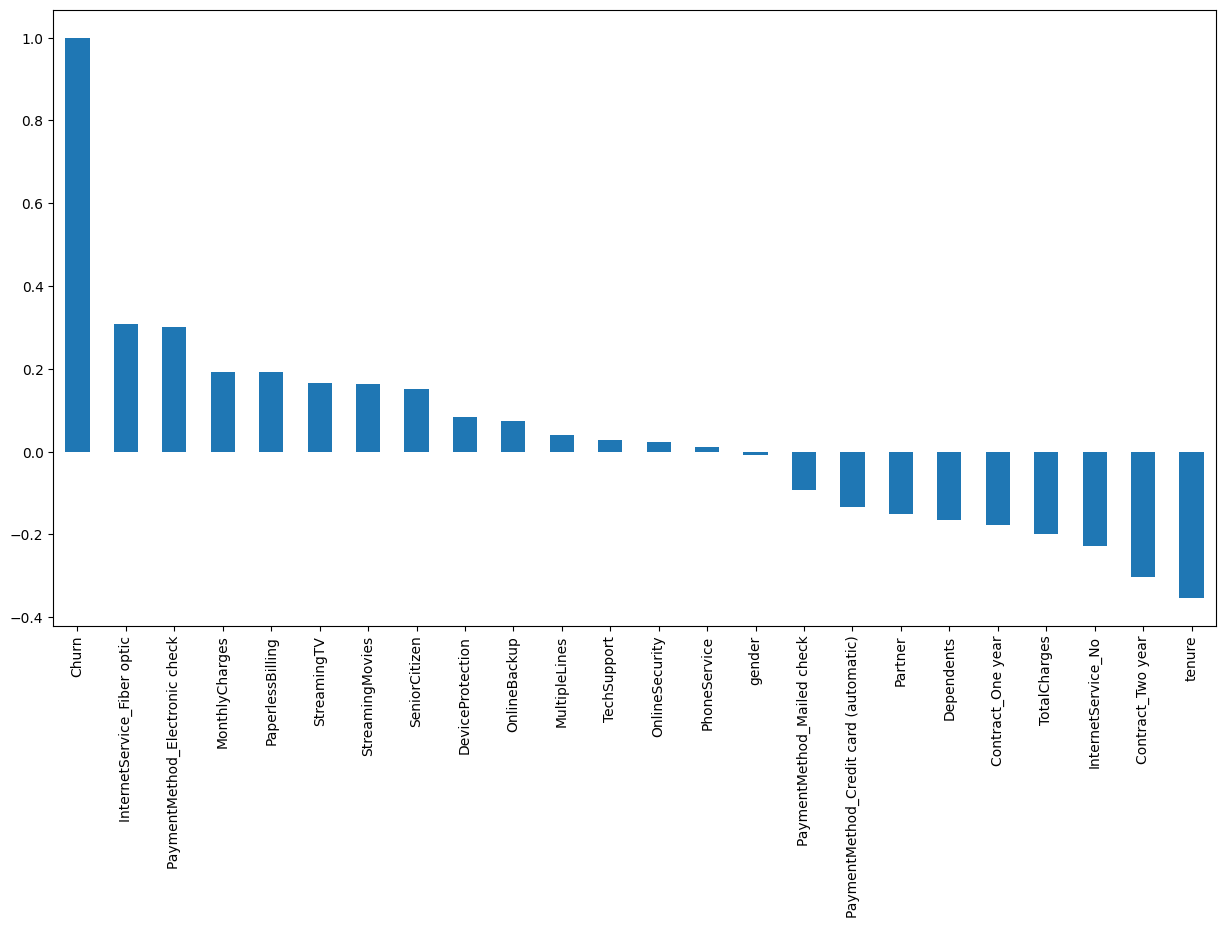

In [124]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [60]:
X=data.drop(["Churn"],axis=1)
y=data["Churn"]

In [138]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

### SMOTE for handling imbalance
- Use only some part of the data to resample so that you use the other data to check for accuracy.
- we shouldn't use resampled data to test the performance of the model

In [139]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [140]:
X_res.shape

(8276, 23)

In [141]:
y_res.value_counts()

0    4138
1    4138
Name: Churn, dtype: int64

In [142]:
clf=xgb.XGBClassifier()
clf.fit(X_res,y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [143]:
def class_report(actual_y,data_to_predict):
    predictions=clf.predict(data_to_predict)
    return classification_report(actual_y,predictions)

In [144]:
print ("\n Train Classification report : \n",class_report(y_res,X_res))


 Train Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4138
           1       0.94      0.96      0.95      4138

    accuracy                           0.95      8276
   macro avg       0.95      0.95      0.95      8276
weighted avg       0.95      0.95      0.95      8276



In [145]:
print ("\n Test Classification report : \n",class_report(y_test,X_test))


 Test Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1036
           1       0.61      0.60      0.61       373

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



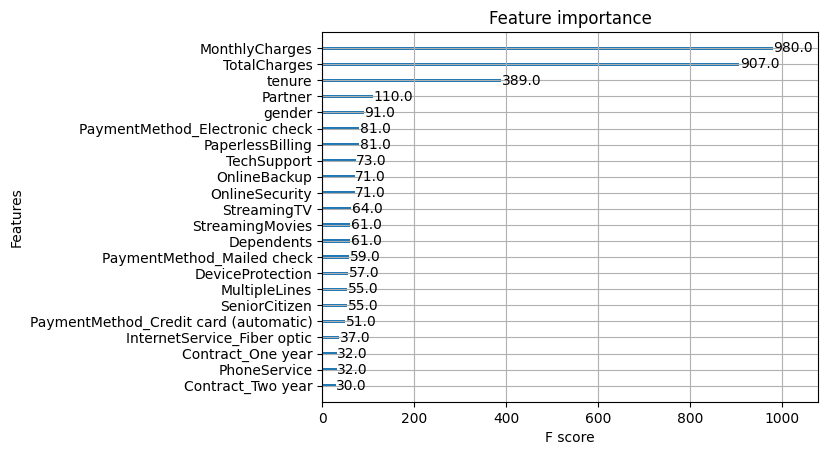

<Figure size 1600x1200 with 0 Axes>

In [146]:
xgb.plot_importance(clf)
plt.figure(figsize = (16, 12))
plt.show()


In [147]:
sk_folds = KFold(n_splits = 10)
model=xgb.XGBClassifier()
scores = cross_val_score(model, X_res, y_res, cv = sk_folds,scoring="f1")

In [148]:
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.61190965 0.59111111 0.5974026  0.64315353 0.60385439 0.57206208
 0.77777778 0.99146341 0.99023199 0.98651961]
Average CV Score:  0.7365486150874572
Number of CV Scores used in Average:  10


In [149]:

roc_scores = cross_val_score(model, X, y, cv = sk_folds,scoring="roc_auc")

In [150]:
print("Cross Validation Scores: ", roc_scores)
print("Average CV Score: ", roc_scores.mean())
print("Number of CV Scores used in Average: ", len(roc_scores))

Cross Validation Scores:  [0.82605473 0.83722371 0.83792707 0.83951554 0.83186486 0.7995085
 0.81579723 0.81681548 0.81803885 0.82608433]
Average CV Score:  0.8248830296415353
Number of CV Scores used in Average:  10


In [151]:

predictions=clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix

array([[891, 145],
       [148, 225]], dtype=int64)

In [152]:
clf.feature_importances_

array([0.01095506, 0.01037654, 0.00824281, 0.02270316, 0.01189045,
       0.0222197 , 0.00814898, 0.0532232 , 0.01814832, 0.01114816,
       0.02544281, 0.01080699, 0.01228364, 0.00646652, 0.01029067,
       0.00830132, 0.01135073, 0.        , 0.28057733, 0.39577958,
       0.02774927, 0.00969038, 0.02420445], dtype=float32)

### Hyperparameter optimization

In [162]:
cv_model= xgb.XGBClassifier()



In [196]:
param_grid = {
    'n_estimators': [50,75,100],
    'learning_rate': [0.001, 0.01,0.05],
    'max_depth': [3, 4,5],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=cv_model,
                       param_grid=param_grid,
                       scoring="f1",
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_res, y_res)



In [197]:
best_xgb_clf.best_score_

0.8234835243931962

In [198]:
best_xgb_clf.best_params_

{'colsample_bytree': 0.75,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 75,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.75}

In [199]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format("recall") + str(np.round(classifier.best_score_, 3)))
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.823


In [200]:
y_pred_pp = cross_val_predict(estimator=best_xgb_clf.best_estimator_,
                                  X=X_test,
                                  y=y_test,
                                  cv=5,
                                  method='predict')

In [201]:
y_pred_pp

array([1, 0, 0, ..., 0, 0, 0])

In [202]:
len(y_pred_pp)

1409

In [203]:
y_res

0       0
1       0
2       1
3       1
4       0
       ..
8271    1
8272    1
8273    1
8274    1
8275    1
Name: Churn, Length: 8276, dtype: int32

In [204]:
cm = confusion_matrix(y_test, y_pred_pp, normalize='true')
cm

array([[0.8957529 , 0.1042471 ],
       [0.47184987, 0.52815013]])

In [205]:
explainer=shap.TreeExplainer(best_xgb_clf,X_train)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.model_selection._search.GridSearchCV'>

In [44]:
shap_values=explainer.shap_values(X_test)

 92%|==================  | 2373/2587 [00:12<00:01]       

In [45]:
explainer.expected_value

0.0947246995685191

In [46]:
y_test.iloc[1]

0

In [47]:
shap.force_plot(explainer.expected_value,shap_values[1],X_test.iloc[1,:])

In [48]:
shap_values[1]

array([ 0.2380985 ,  0.04519827, -0.18298294, -0.61905936, -0.91271864,
       -0.07825575,  0.15381831,  0.19161531, -0.74694818, -0.41147669,
       -1.34156323, -0.03652297, -0.54821341, -0.08300641,  3.55111753,
        0.06532311, -0.26229541,  0.04671333, -1.12888511,  0.25746531,
        0.06056776, -0.15146851,  0.14364917])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


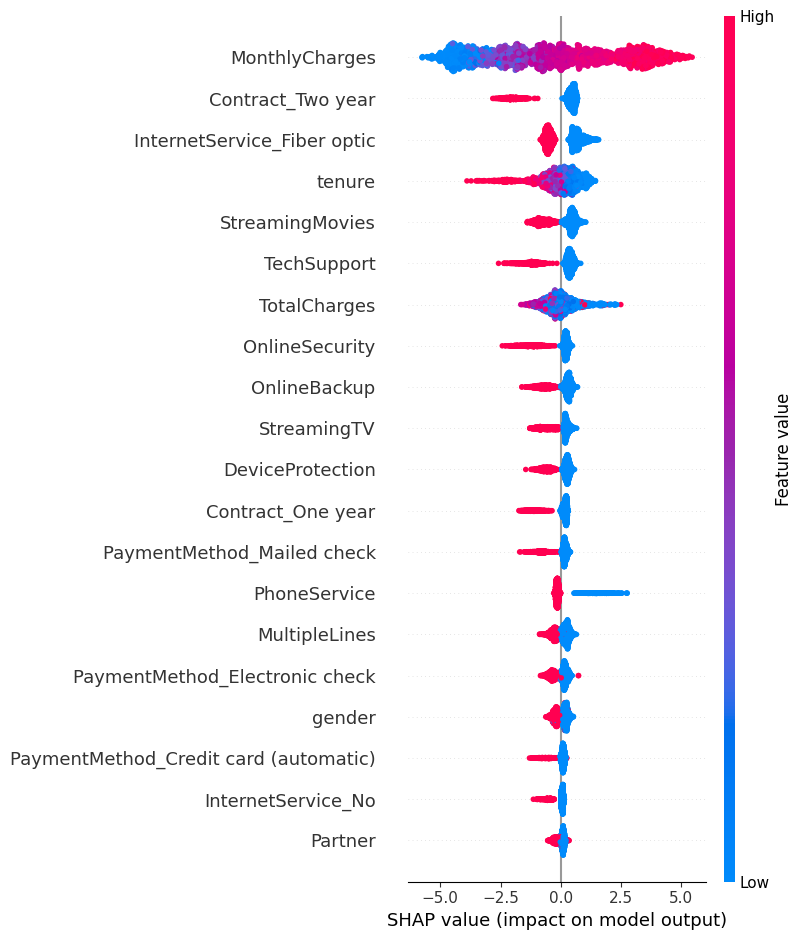

In [49]:
shap.summary_plot(shap_values, X_test)



In [50]:
shap_values=explainer(X_test[:1])


In [51]:
shap_values

.values =
array([[-5.86714059e-02,  2.90970453e-02, -7.32353085e-04,
         1.49846120e-01, -1.26336539e+00,  2.06788145e+00,
         7.59636788e-02, -1.18313133e+00, -4.80636447e-01,
        -3.53427959e-01,  3.10021860e-01,  8.71889969e-02,
        -5.79583616e-01,  1.80897161e-02, -8.07645658e-01,
        -5.10724954e-01,  6.09021577e-01,  2.80415572e-02,
         7.25712112e-02, -1.10088331e+00,  1.49657692e-02,
         7.44521910e-01,  1.25905201e-01]])

.base_values =
array([0.0947247])

.data =
array([[0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 7.20000e+01,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 4.92000e+01,
        3.58095e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00]])

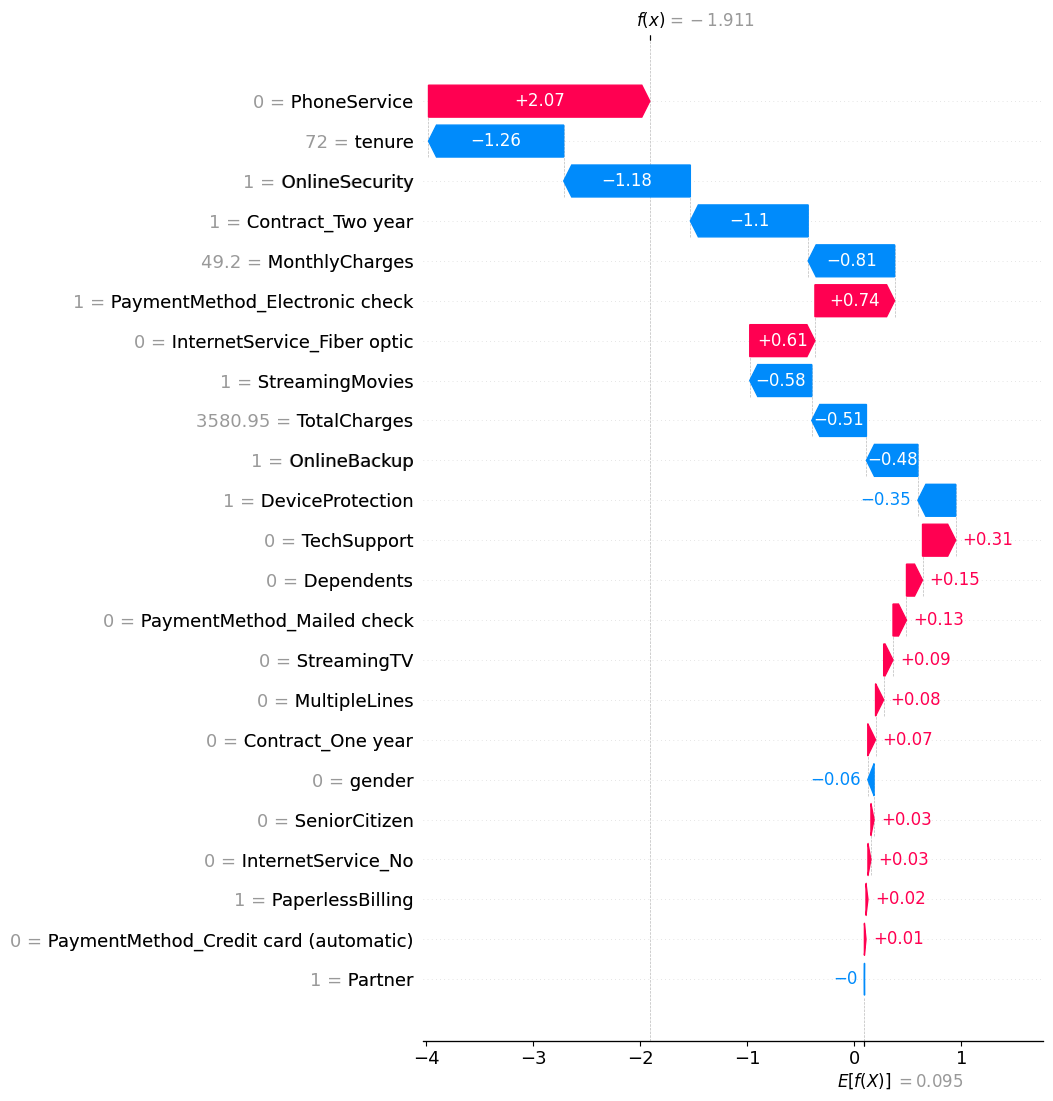

In [52]:
shap.waterfall_plot(shap_values[0],max_display=len(X.columns))